In [1]:
import os
import os.path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
sns.set()

In [17]:
datadir = "data/tidy_data"
data = os.path.join(datadir, "compiled_jump_data.csv")
df_jump = pd.read_csv(data)

# Importing the dataset
datadir = "data/tidy_data"
data = os.path.join(datadir, "coded_injuries.csv")
df_injuries = pd.read_csv(data)

# Function for converting date format from American to ISO formatting
def date_coversion(date):
    date_object = datetime.strptime(date, '%m-%d-%Y')
    iso_format_date = date_object.strftime('%Y-%m-%d')
    return iso_format_date

# Changing date formatting
df_injuries.drop(columns = ["DateOfReturn", "ReportedDate"], inplace = True)
df_injuries["ProblemDate"] = df_injuries["ProblemDate"].str.replace("/", "-").apply(date_coversion)
df_injuries["ProblemDate"] = pd.to_datetime(df_injuries["ProblemDate"])

# Filling NA's
df_injuries["Side"] = df_injuries["Side"].fillna("Does Not Apply")

In [24]:
numeric_columns = df_jump.select_dtypes(include=['number']).columns
correlation_matrix = df_jump[numeric_columns].corr()

correlation_matrix_abs = correlation_matrix.abs().unstack().sort_values(ascending=False)
top_correlations = correlation_matrix_abs[correlation_matrix_abs < 1.0].drop_duplicates().head(30)

top_correlations

Propulsive Net Impulse               Jump Momentum                           0.999958
Relative Propulsive Net Impulse      Takeoff Velocity                        0.999902
Peak Braking Velocity                Relative Braking Net Impulse            0.999822
Peak Velocity                        Takeoff Velocity                        0.997796
Relative Propulsive Net Impulse      Peak Velocity                           0.997624
L|R Avg. Braking Force               L|R Braking Impulse Index               0.997373
Jump Height                          Takeoff Velocity                        0.996672
                                     Relative Propulsive Net Impulse         0.996582
L|R Avg. Landing Force               L|R Landing Impulse Index               0.996136
Jump Height                          Peak Velocity                           0.995234
L|R Avg. Propulsive Force            L|R Propulsive Impulse Index            0.994254
Peak Braking Force                   Force at Min Disp

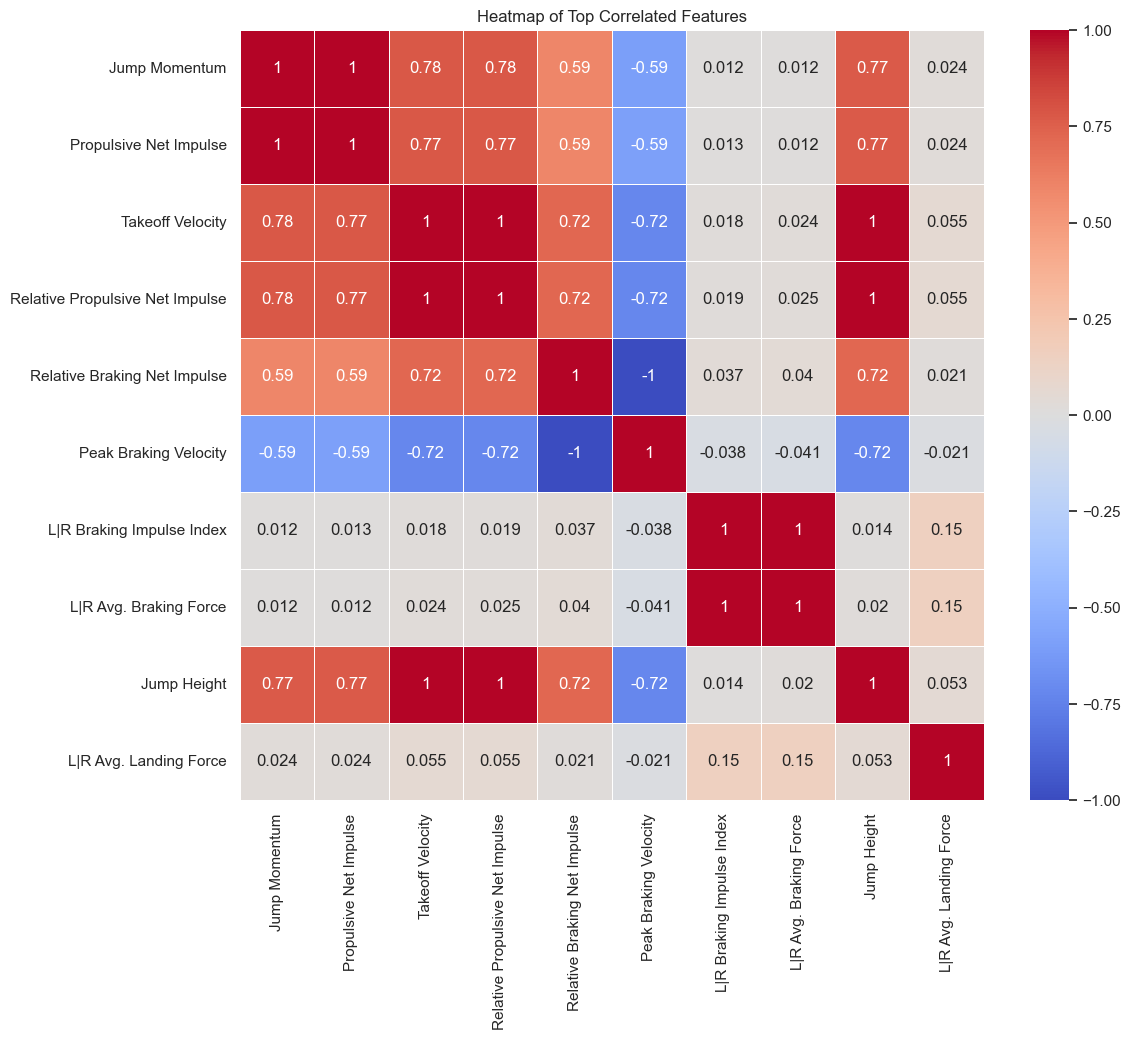

In [4]:
top_features = ['Jump Momentum', 'Propulsive Net Impulse', 'Takeoff Velocity', 
                'Relative Propulsive Net Impulse', 'Relative Braking Net Impulse', 
                'Peak Braking Velocity', 'L|R Braking Impulse Index', 
                'L|R Avg. Braking Force', 'Jump Height', 'L|R Avg. Landing Force']

plt.figure(figsize=(12, 10))
sns.heatmap(df_jump[top_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Heatmap of Top Correlated Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

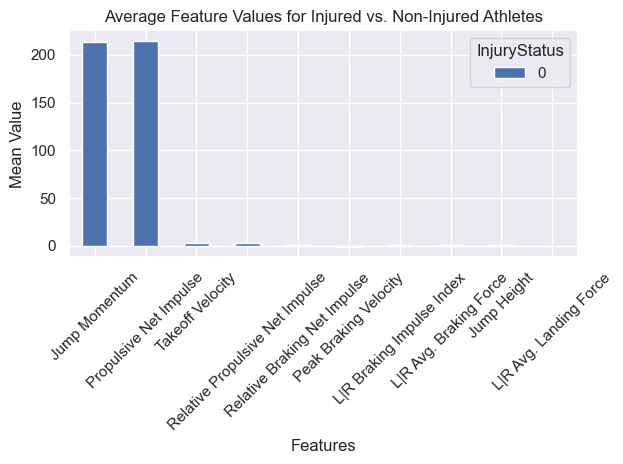

In [5]:
# Assume `injury_status` column exists (create it if needed)
df_jump['InjuryStatus'] = df_jump['TestId'].apply(lambda x: 1 if x in df_injuries['Code'].values else 0)

# Plot mean comparison
plt.figure(figsize=(12, 6))
df_jump.groupby('InjuryStatus')[top_features].mean().transpose().plot(kind='bar')
plt.title("Average Feature Values for Injured vs. Non-Injured Athletes")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Mean Squared Error: 0.00212570708137963
R-squared: 0.9045269072953742


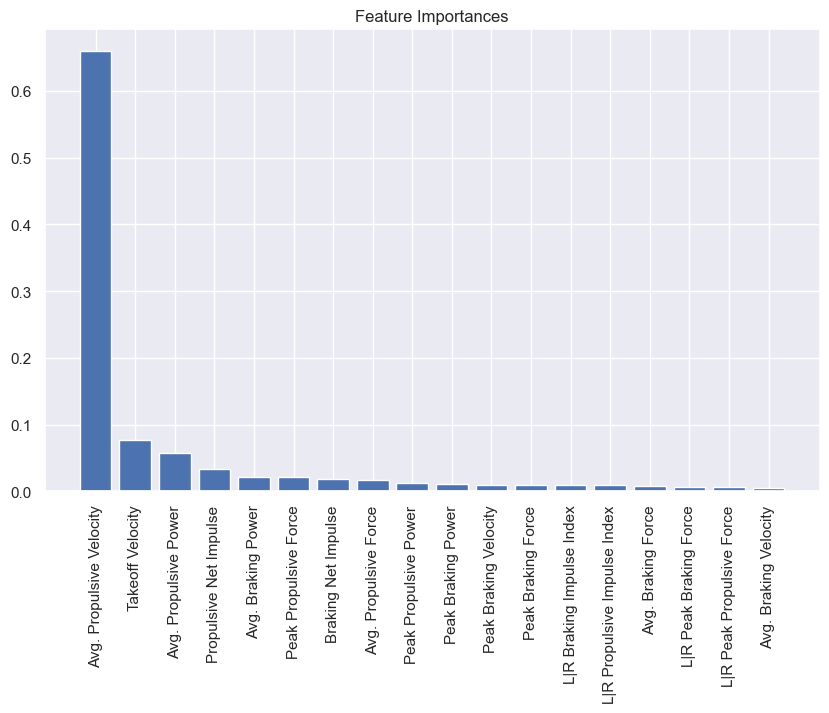

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select relevant columns
jump_data = df_jump[[
    'TestId', 'Peak Braking Force', 'Avg. Braking Force', 'Braking Net Impulse',
    'Peak Propulsive Force', 'Avg. Propulsive Force', 'Propulsive Net Impulse',
    'Avg. Braking Velocity', 'Peak Braking Velocity', 'Avg. Propulsive Velocity',
    'Takeoff Velocity', 'Avg. Braking Power', 'Peak Braking Power', 'Avg. Propulsive Power',
    'Peak Propulsive Power', 'L|R Peak Braking Force', 'L|R Peak Propulsive Force',
    'L|R Braking Impulse Index', 'L|R Propulsive Impulse Index', 'mRSI'
]]

jump_data.set_index("TestId", inplace= True)
# Handle missing values by dropping rows with NaNs
jump_data = jump_data.dropna()

# Split data into training and testing sets
X = jump_data.drop(columns=['mRSI'])
y = jump_data['mRSI']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Train Random Forest model with cross-validation
rf_model = RandomForestRegressor(n_estimators=100, random_state=123)
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
rf_model.fit(X_train, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test)

# Model performance evaluation
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Variable Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
plt.show()

In [19]:
# Assuming jump_data is already loaded
jump_data['mRSI_Category'] = pd.cut(
    jump_data['mRSI'],
    bins=[-float('inf'), 0.3, 0.6, 0.8, 1.05],
    labels=["Low", "Moderate", "Well Established", "High Level"]
)

# Drop the original mRSI column if only using mRSI_Category
jump_data = jump_data.drop(columns=['mRSI'])

# Display the updated DataFrame
print(jump_data.head())

                      Peak Braking Force  Avg. Braking Force  \
TestId                                                         
wcA34uNwALX62RXbKVTO              1561.0           1188.0265   
LkttfcWITL6DKtlpgIaD              1585.0           1206.8407   
9b1gZ7sAEwJd6qvfskBv              1483.0           1089.1908   
I7TxqDrUVsplw7tDf2TI              1528.0           1120.3496   
3nu89oIbjIUElAGpTJDM              1483.0           1066.8120   

                      Braking Net Impulse  Peak Propulsive Force  \
TestId                                                             
wcA34uNwALX62RXbKVTO              63.5692                 1588.0   
LkttfcWITL6DKtlpgIaD              65.5930                 1591.0   
9b1gZ7sAEwJd6qvfskBv              60.9083                 1520.0   
I7TxqDrUVsplw7tDf2TI              60.8044                 1544.0   
3nu89oIbjIUElAGpTJDM              58.5685                 1487.0   

                      Avg. Propulsive Force  Propulsive Net Impulse  \
Tes

Accuracy: 80.09%


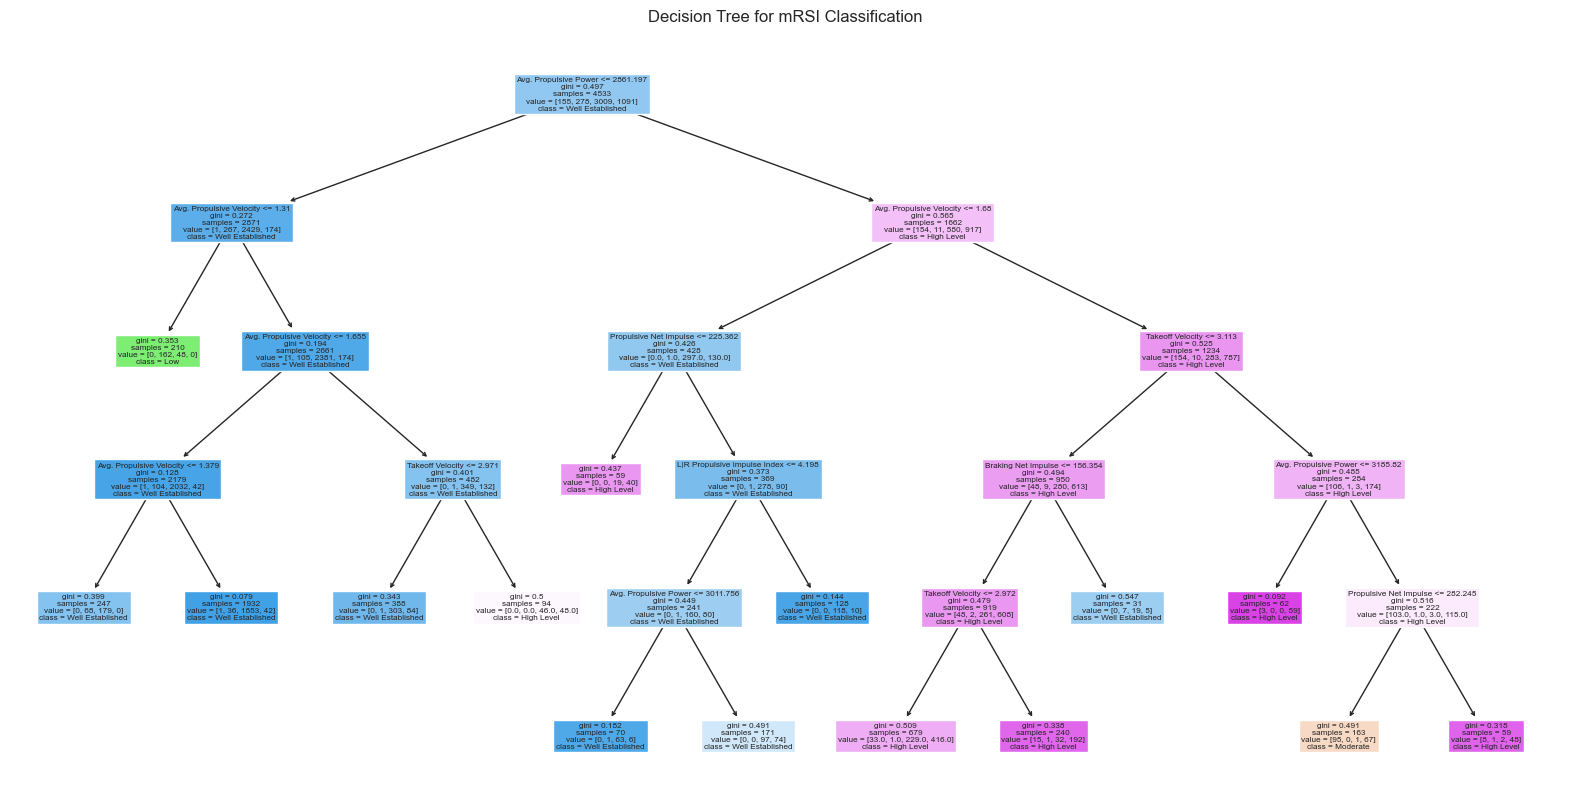

In [23]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

# Assuming 'jump_data' is already loaded and preprocessed
# Splitting data into features and labels
X = jump_data.drop(columns=['mRSI_Category'])  # Features
y = jump_data['mRSI_Category']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Fit a decision tree model
tree_model = DecisionTreeClassifier(
    random_state=123,
    max_depth=5,  # Limit the depth of the tree
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=5,  # Minimum samples required at a leaf node
    max_leaf_nodes=15  # Limit the number of leaf nodes
)
tree_model.fit(X_train, y_train)

# Predict on the test set
predictions = tree_model.predict(X_test)

# Evaluate the model performance
conf_matrix = confusion_matrix(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)

# Print the accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=y.unique(), filled=True)
plt.title("Decision Tree for mRSI Classification")
plt.show()